In [38]:
import torch
import torch
from torchvision import datasets, transforms
from torchvision.transforms import ToTensor
from torch.utils.data import Dataset
from mediapipe_handcrop import MediapipeHandCrop
import os
import cv2
from PIL import Image
import random
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np

In [39]:
def setup_device():
    if torch.cuda.is_available():
        device = torch.device('cuda')
        torch.set_default_dtype(torch.float32)
    else:
        device = torch.device('cpu')
        torch.set_default_dtype(torch.float32)
    return device

device = setup_device()
print(f"Using {device} device")

# Set random seed for reproducibility
torch.manual_seed(42)
torch.cuda.manual_seed_all(42)

Using cuda device


## New Test Dataset

In [40]:
transform = transforms.Compose([
    MediapipeHandCrop(max_num_hands=1, min_detection_confidence=0.5),  
    transforms.Resize((224, 224)), 
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


## Create DataFrame for new test dataset

In [41]:
import os
import pandas as pd

# Directory containing the dataset
ROOT_DIR = "./asl_test_dataset"

data = []

for label in os.listdir(ROOT_DIR):
    label_dir = os.path.join(ROOT_DIR, label)
    
    if os.path.isdir(label_dir):
        for file_name in os.listdir(label_dir):
            file_path = os.path.join(label_dir, file_name)
            data.append({"file_path": file_path, "file_name": file_name, "label": label})

# Create a DataFrame
test_df = pd.DataFrame(data)

# Save DataFrame to CSV
CSV_FILE = "./asl_test_dataset/asl_dataset_csv.csv"
test_df.to_csv(CSV_FILE, index=False)

print(f"CSV file saved at {CSV_FILE}")


CSV file saved at ./asl_test_dataset/asl_dataset_csv.csv


In [42]:
df = pd.read_csv(CSV_FILE)
df.head()

,file_path,file_name,label
0,./asl_test_dataset\A\a.png,a.png,A
1,./asl_test_dataset\A\Pasted image (2).png,Pasted image (2).png,A
2,./asl_test_dataset\A\Pasted image (3).png,Pasted image (3).png,A
3,./asl_test_dataset\A\Pasted image (4).png,Pasted image (4).png,A
4,./asl_test_dataset\A\Pasted image (5).png,Pasted image (5).png,A


In [43]:
class NewTestDataset(Dataset):
    def __init__(self, root_dir, csv_file, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.csv_file = csv_file
        self.df = pd.read_csv(self.csv_file)
        self.classes = sorted([class_name for class_name in os.listdir(self.root_dir) if os.path.isdir(os.path.join(self.root_dir, class_name))])

        # Maping class names to numbers 
        self.class_to_idx = {class_name: idx for idx, class_name in enumerate(self.classes) if os.path.isdir(os.path.join(self.root_dir, class_name))}

    def __len__(self):
        # Zsumuj liczbę plików w podkatalogach
        dataset_len = sum(
            len(os.listdir(os.path.join(self.root_dir, class_)))
            for class_ in self.classes
            if os.path.isdir(os.path.join(self.root_dir, class_))
        )
        return dataset_len
    
    def __getitem__(self, idx):
        if idx >= len(self):
            raise IndexError("Index out of bounds")
        
        image_path = self.df.loc[idx, "file_path"]
        
        # Debuging label
        # label = os.path.join(self.root_dir,
        #                      self.df.loc[idx, 'label'])
        label = self.df.loc[idx, 'label']
                                                     
         # Loading image with cv2
        image = cv2.imread(image_path, cv2.IMREAD_COLOR)
        if image is None:
            raise FileNotFoundError(f"Image not found: {image_path}")
        
        # Converting to RGB
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        # # Transform
        if self.transform:
            image = self.transform(Image.fromarray(image))
        
        return image, label
        

In [44]:
# Train dataset and dataloader initialization
new_test_dataset = NewTestDataset(root_dir=ROOT_DIR, 
                        csv_file=CSV_FILE, 
                        transform=transform,
                        )

## Sanity check

Dataset len:
203

Dataset classes:
['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']

Random images from dataset:


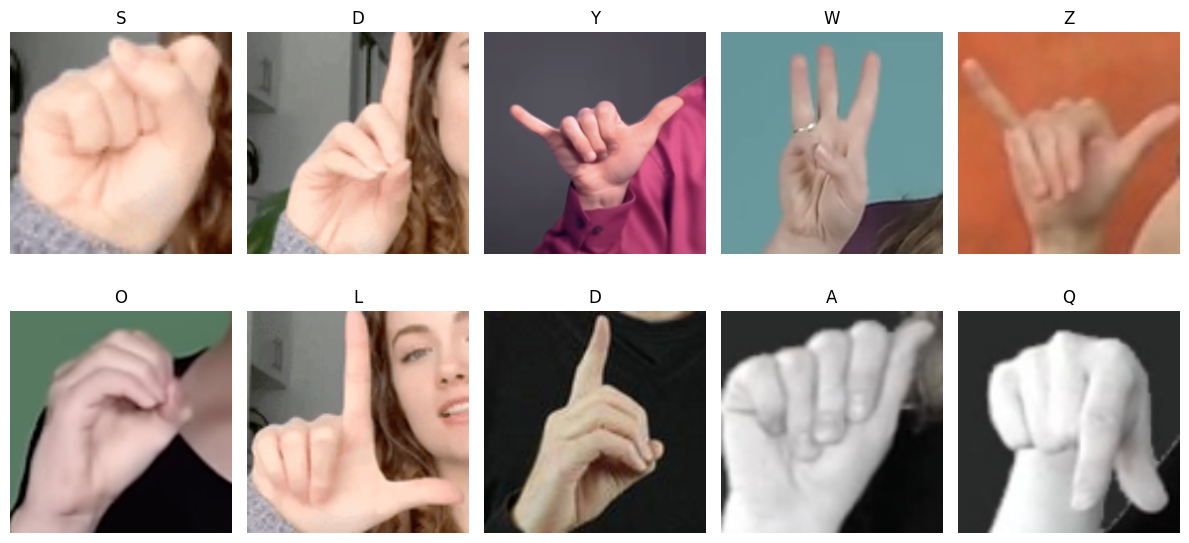

In [45]:
# Sanity check
print("Dataset len:")
print(len(new_test_dataset))

print("\nDataset classes:")
print(new_test_dataset.classes)

print("\nRandom images from dataset:")

plt.figure(figsize=(12,6))
for i in range(10):
    # Fetch image
    img, label = new_test_dataset[random.randint(0, len(new_test_dataset)-1)]
    image = img.permute(1, 2, 0).numpy()  # [C, H, W] -> [H, W, C]

    # Denormalizing (there was normalization in transform)
    mean = [0.485, 0.456, 0.406]
    std = [0.229, 0.224, 0.225]
    image = image * std + mean
    image = image.clip(0, 1)

    plt.subplot(2,5,i+1)
    plt.imshow(image)
    plt.axis("off")
    plt.title(label)

plt.tight_layout()
plt.show()

In [46]:
def predict_image(img, model, device, class_names):
    # Wczytanie i przetworzenie obrazu
    transform = transforms.Compose([
        transforms.Resize((224, 224)),  # Rozmiar wejścia dla ResNet50
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # Normalizacja ImageNet
    ])

    # image = img.convert('RGB')  # Konwersja na RGB
    image_tensor = img.unsqueeze(0).to(device)  # Dodanie wymiaru wsadowego

    model.to(device)
    # Przewidywanie
    model.eval()
    with torch.inference_mode():
        outputs = model(image_tensor)
        _, predicted = outputs.max(1)

    # Zwracanie nazwy klasy
    predicted_class = class_names[predicted.item()]
    return predicted_class


In [47]:
def visualize_model_predictions(model, test_dataset):
    plt.figure(figsize=(12,6))
    for i in range(10):
        # Fetch image
        img, label = test_dataset[random.randint(0, len(test_dataset)-1)]
        image = img.permute(1, 2, 0).numpy()  # [C, H, W] -> [H, W, C]
        class_names = test_dataset.classes

        # Denormalizing (there was normalization in transform)
        mean = [0.485, 0.456, 0.406]
        std = [0.229, 0.224, 0.225]
        image = image * std + mean
        image = image.clip(0, 1)

        # Predicting image class with loaded model
        model.to()
        y_pred = predict_image(img, model, device, class_names)

        plt.subplot(2,5,i+1)
        plt.imshow(image)
        plt.axis("off")
        plt.title(f"class: {label}\n predicted class: {y_pred}")

    plt.tight_layout()
    plt.show()

## Loading ResNet model

In [48]:
resnet_model = torch.load(f="./models/Resnet50_test1_model", weights_only=False)
resnet_model.to(device)
print(resnet_model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

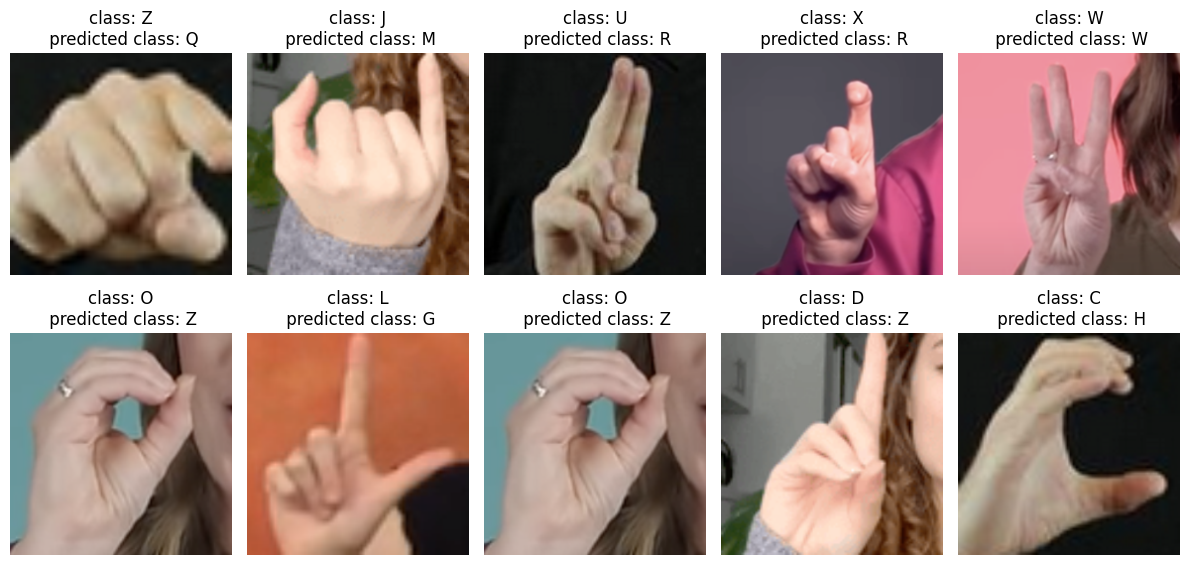

In [49]:
visualize_model_predictions(model=resnet_model,
                            test_dataset=new_test_dataset)

## Loading MobileNet model

In [50]:
mobilenet_model = torch.load(f="./models/MobileNet_test1_model", weights_only=False)
mobilenet_model.to(device)
print(mobilenet_model)

MobileNetV2(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=

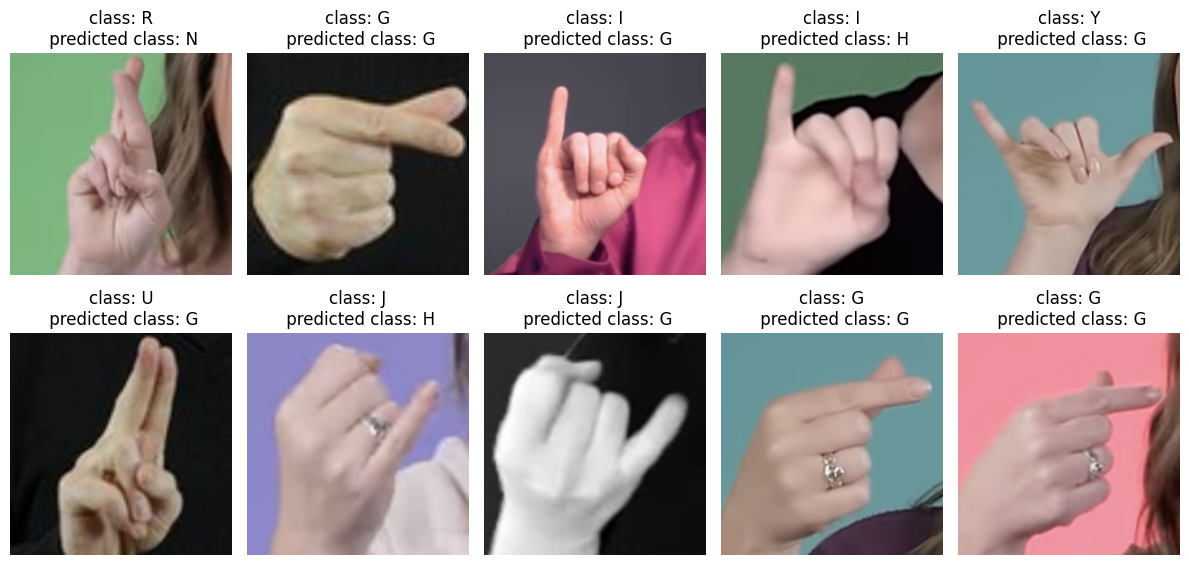

In [51]:
visualize_model_predictions(model=mobilenet_model,
                            test_dataset=new_test_dataset)